# Taller de refuerzo de Keras (II)

En este taller, realizaremos los pasos necesarios para construir una red neuronal convolucional (CNN) 3D para predecir la presencia de neumonía viral en tomografías computarizadas (TC). Las CNN 2D se utilizan comúnmente para procesar imágenes RGB (3 canales). Una CNN 3D es simplemente el equivalente en 3D: toma como entrada un volumen 3D o una secuencia de cuadros 2D (por ejemplo, cortes en una tomografía computarizada). Sin duda, las CNN 3D son un modelo poderoso para aprender representaciones de datos volumétricos.

## Carga de librerías, módulos y funciones


In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

import nibabel as nib

from scipy import ndimage

from sklearn.model_selection import train_test_split

## Carga de datos y preprocesamiento

Usaremos un subconjunto de MosMedData que consta de tomografías computarizadas de pulmón con hallazgos relacionados con COVID-19, así como algunas sin tales hallazgos.

Usaremos los hallazgos radiológicos asociados de las tomografías computarizadas como etiquetas para construir un clasificador para predecir la presencia de neumonía viral. Por tanto, la tarea es un problema de clasificación binaria.

### Descarga de datos

In [ ]:
# # Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

if not os.path.exists("MosMedData"):
  # Make a directory to store the data.
  os.makedirs("MosMedData")

  # Unzip data in the newly created directory.
  with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
      z_fp.extractall("./MosMedData/")

  with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
      z_fp.extractall("./MosMedData/")

1045168128/1045162547 [==============================] - 95s 0us/step


### Procesamiento de datos

Para procesar los datos, hacemos lo siguiente:

- Primero giramos los volúmenes 90 grados, por lo que la orientación es fija.
- Escalamos algunos valores para que estén entre 0 y 1.
- Redimensionamos ancho, alto y profundidad.


Para ello, definimos varias funciones auxiliares de procesamiento de datos. Estas funciones se utilizarán al crear conjuntos de datos de entrenamiento y evaluación.

In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

A continuación, leemos las rutas de los escaneos CT de los directorios de clases.

In [ ]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CTs con tejido normal de pulmón: " + str(len(normal_scan_paths)))
print("CTs con tejido anormal de pulmón: " + str(len(abnormal_scan_paths)))

CTs con tejido normal de pulmón: 100
CTs con tejido anormal de pulmón: 100


- Leeremos ahora los escaneos de los directorios de clases y asignaremos etiquetas. 
- Además, dividiremos el conjunto de datos en subconjuntos de train y test.

In [ ]:
# Lectura de escáneres
# Resize
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

In [ ]:
# Para los CTs con presencia de virus de neumonía
# crea una variable llamada abnormal_labels que contenga
# etiquetas con valor 1
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])


In [ ]:
# Para los CTs sin presencia de virus de neumonía
# crea una variable llamada normal_labels que contenga
# etiquetas con valor 0
normal_labels = np.array([0 for _ in range(len(normal_scans))])

In [ ]:
# Concatena abnormal_scans y normal_scans con np.concatenate()
# La variable resultante debe llamarse scans
scans = np.concatenate((abnormal_scans, normal_scans), axis=0)

In [ ]:
# Concatena abnormal_labels y normal_labels con np.concatenate()
# La variable resultante debe llamarse labels
labels = np.concatenate((abnormal_labels, normal_labels), axis=0)

### Particiones de entrenamiento y test

In [ ]:
# Crea una partición de train (70% de los datos) y otra de test (30%)
# Fija una semilla de 42 para garantizar la repetibilidad de los resultados
X_train, X_test, y_train, y_test = train_test_split(scans, labels, test_size= 0.3, random_state=42)

In [ ]:
# Comprueba que los resultados obtenidos son los siguientes:
print(f"Hay {X_train.shape[0]} muestras de entrenamiento y {X_test.shape[0]} muestras de test")

Hay 140 muestras de entrenamiento y 60 muestras de test


### Visualización

Dimensiones: (128, 128, 64)


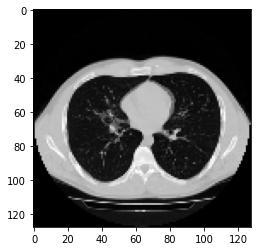

In [ ]:
# Muestra una de las imágenes de entrenamiento
image = X_train[0]

print("Dimensiones:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

Dado que una tomografía computarizada tiene muchos cortes, visualicemos un montaje de los cortes.

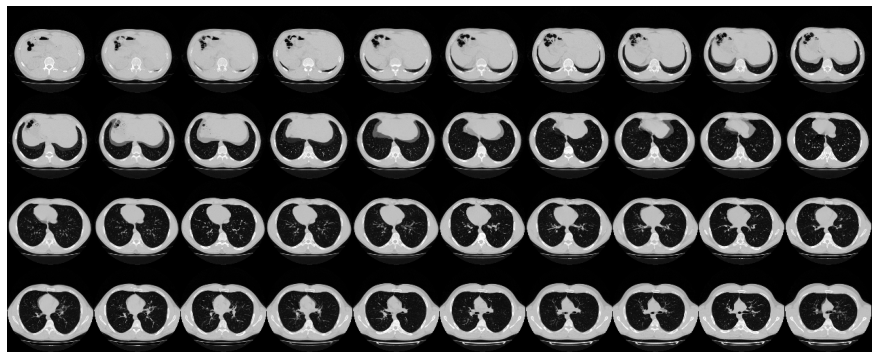

In [ ]:
# Ejecuta esta celda para mostrar los gráficos
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# 4 filas y 10 columnas para 100 slices del escáner CT
plot_slices(4, 10, 128, 128, image[:, :, :40])

### Cargadores de datos para alimentar el modelo

In [ ]:
# Data loaders
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Dado que los datos se almacenan en tensores de forma de rango 3 (samples, height, width, depth), agregamos una dimensión de tamaño 1 en el eje 4 para poder realizar convoluciones 3D en los datos. La nueva forma es así (samples, height, width, depth, 1).

In [ ]:
def add_dimension(volume, label):
    """ Añadimos una dimensión adicional """
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
batch_size = 2

# Aplicamos el tamaño de batch, 
train_dataset = (train_loader.shuffle(len(X_train))
    .map(add_dimension)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(X_test))
    .map(add_dimension)
    .batch(batch_size)
    .prefetch(2)
)

## Definición de una red neuronal convolucional 3D

Para que el modelo sea más fácil de entender, lo estructuraremos en bloques. La arquitectura de la CNN 3D utilizada en este ejemplo se basa en este documento: https://arxiv.org/abs/2007.13224

El modelo se llamará 3D_CNN y estará compuesta por:

- Bloque 1:
  - Una capa Conv3D con 64 filtros de salida en la convolución, tamaño 3 de kernel y activación ReLu. Recuerda que, al ser la primera capa, requiere que se especifique el tamaño de entrada de los datos.
  - Una operación de MaxPool3D (que se introduce como una capa adicional de Keras), con tamaño 2 de pool.

- Bloque 2:
  - Una operación de BatchNormalization (que también se introduce como una capa adicional de Keras).
  - Una capa Conv3D con 64 filtros de salida en la convolución, tamaño 3 de kernel y activación ReLu.
  - Una operación de MaxPool3D (que se introduce como una capa adicional de Keras), con tamaño 2 de pool.

- Bloque 3
  - Una operación de BatchNormalization (que también se introduce como una capa adicional de Keras).
  - Una capa Conv3D con 128 filtros de salida en la convolución, tamaño 3 de kernel y activación ReLu.
  - Una operación de MaxPool3D (que se introduce como una capa adicional de Keras), con tamaño 2 de pool.

- Bloque 4
  - Una operación de BatchNormalization (que también se introduce como una capa adicional de Keras).
  - Una capa Conv3D con 256 filtros de salida en la convolución, tamaño 3 de kernel y activación ReLu.
  - Una operación de MaxPool3D (que se introduce como una capa adicional de Keras), con tamaño 2 de pool.

- Bloque 5
  - Una operación de BatchNormalization (que también se introduce como una capa adicional de Keras).
  - Una operación de GlobalAveragePooling3D (que también se introduce como una capa adicional de Keras).
  - Una capa densa de 512 unidades y activación ReLu.
  - Una operación de Dropout (que también se introduce como una capa adicional de Keras), con ratio 0.3.

- Capa de salida de tipo Denso, con una cantidad de neuronas y una función de activación apropiadas para este tipo de problema.


### Batch normalization
La normalización es una categoría amplia de métodos que buscan hacer que las diferentes muestras vistas por un modelo de aprendizaje automático sean más similares entre sí, lo que ayuda al modelo a aprender y generalizar bien a nuevos datos. La forma más común de normalización de datos consiste en centrar los datos en cero restando la media de los datos y dar a los datos una desviación estándar unitaria dividiendo los datos por su desviación estándar. En efecto, esto supone que los datos siguen una distribución normal (o gaussiana) y asegura que esta distribución esté centrada y escalada a la varianza de la unidad.

`normalized_data = (data - np.mean(data, axis=...)) / np.std(data, axis=...)`

Es habitual normalizar los datos antes de introducirlos en una red neuronal. Pero esto solo tiene efecto en la primera capa, ya que la normalización de los datos puede perderse después de cada transformación operada por la red: incluso si los datos que se introducen a una red Dense o Conv2D tienen una media de 0 y una varianza unitaria, no hay razón para esperar a priori que este sea el caso de los datos que salen. Para solucionar esto, se utiliza la normalización de las activaciones intermedias o normalización por lotes ("capa" BatchNormalization en Keras).

In [ ]:
model = Sequential(name="3D_CNN")

# Bloque 1
model.add(layers.Conv3D(filters=64, 
                        kernel_size=3, 
                        activation="relu",
                        input_shape = (128, 128, 64, 1)))
model.add(layers.MaxPool3D(pool_size=2))

# Bloque 2
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(filters=64, 
                        kernel_size=3, 
                        activation="relu"))
model.add(layers.MaxPool3D(pool_size=2))

# Bloque 3
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(filters=128, 
                        kernel_size=3, 
                        activation="relu"))
model.add(layers.MaxPool3D(pool_size=2))

# Bloque 4
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(filters=256, 
                        kernel_size=3, 
                        activation="relu"))
model.add(layers.MaxPool3D(pool_size=2))

# Bloque 5
model.add(layers.BatchNormalization())
model.add(layers.GlobalAveragePooling3D())
model.add(layers.Dense(units=512, activation="relu"))
model.add(layers.Dropout(0.3))

# Capa de salida
model.add(layers.Dense(units=1, activation="sigmoid"))

In [ ]:
# Muestra el modelo con el método summary()
model.summary()

Model: "3D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 28, 28, 12, 128)   22131

## Compilación del modelo


In [ ]:
# Compila el modelo anterior, utilizando una pérdida, un optimizador y una
# métrica de monitorización que consideres apropiados para este problema
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Ajuste del modelo

In [ ]:
# Define un callback para guardar el modelo 
checkpoint = keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only=True)


In [ ]:
# Define un callback de early stopping que monitoree el accuracy de validación 
# y tenga paciencia máxima para 15 epochs
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15)

In [ ]:
# Ajusta el modelo, realizando una validación al final de capa epoch
# Fija el número de epochs máximas en 100
# Aplica shuffle a los datos
# Fija la verbosidad en 2
# Aplica los callbacks definidos en las celdas anteriores
epochs = 2
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[early_stopping],
)

Epoch 1/2
70/70 - 1553s - loss: 0.7112 - accuracy: 0.5714 - val_loss: 1.7253 - val_accuracy: 0.5000
Epoch 2/2
70/70 - 1546s - loss: 0.6591 - accuracy: 0.6000 - val_loss: 1.7332 - val_accuracy: 0.5000


## Evaluación

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Predicción

In [ ]:
# Carga los mejores pesos del modelo
model.load_weights("3d_image_classification.h5")

In [ ]:
# Realiza predicciones para el dataset de test
# Para ello, ejecuta esta celda
prediction = model.predict(np.expand_dims(X_test[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "anormal"]
for score, name in zip(scores, class_names):
    print(
        "Este modelo tiene una confianza del %.2f % de que este escáner CT es %s"
        % ((100 * score), name)
    )

## Ampliaciones

### Primer experimento

A continuación, aplicaremos la técnica de Data Augmentation. Para ello, existen varias opciones, de las cuales optaremos por la que consiste en aplicar técnicas de variación de imágenes a modo de capas de preprocesamiento dentro de un modelo secuencial de Keras.

Ejemplo:

`data_augmentation = Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])`


En este caso, RandomFlip voltea aleatoriamente cada imagen horizontal y verticalmente, mientras que RandomRotation la rota aleatoriamente en base a una fracción de 2pi en sentido antihorario (consultar documentación).

A continuación, se podría añadir este pequeño modelo a otro modelo secuencial, tal y como se muestra a continuación:

`model = tf.keras.Sequential([`

  `resize_and_rescale,`

  `data_augmentation,`

  `layers.Conv2D(16, 3, padding='same', activation='relu'),`

  `layers.MaxPooling2D(),`

  `# Resto del modelo`

`])`

Ahora, puedes continuar definir un nuevo modelo replicando la arquitectura del modelo que utilizamos en el caso de uso anterior y añadiendo capas de preprocesamiento al principio, con el fin de aplicar la técnica de Data Augmentation. Llámale 3D_CNN_DA, entrénalo y evalúalo.

### Segundo experimento

Explora la clase ImageDataGenerator de Keras, que genera lotes de datos de imágenes de tensores con aplicación de data augmentation en tiempo real.